# Notebook 1 - Simple Analyzer

This notebook takes CMS OpenData nanoAOD files, applies some selection and make few simple plots. 

Let's first load the libraries:

In [1]:
import asyncio
import logging
import os
import time

import vector; vector.register_awkward()
import awkward as ak
from coffea import processor
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
import hist
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import uproot

In [2]:
ifile = uproot.open("https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root")
ifile["Events"].keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage1_2_cat_pTjet25GeV',
 'HTXS_stage1_2_cat_pTjet30GeV',
 'HTXS_stage1_2_fine_cat_pTjet25GeV',
 'HTXS_stage1_2_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'btagWeight_CSVV2',
 'btagWeight_DeepCSVB',
 'CaloMET_phi',
 'CaloMET_pt',
 'CaloMET_sumEt',
 'ChsMET_phi',
 'ChsMET_pt',
 'ChsMET_sumEt',
 'nCorrT1METJet',
 'CorrT1METJet_area',
 'CorrT1METJet_eta',
 'CorrT1METJet_muonSubtrFactor',
 'CorrT1METJet_phi',
 'CorrT1METJet_rawPt',
 'DeepMETResolutionTune_phi',
 'DeepMETResolutionTune_pt',
 'DeepMETResponseTune_phi',
 'DeepMETResponseTune_pt',
 'nElectron',
 'Electron_deltaEtaSC',
 'Electron_dr03EcalRecHitSumEt',
 'Electron_dr03HcalDepth1TowerSumEt',
 'Electron_dr03TkSumPt',
 'Electron_dr03T

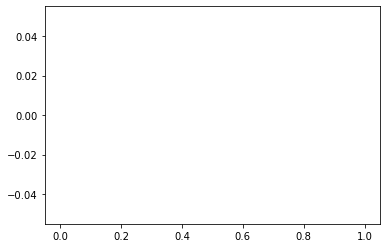

In [3]:
plt.hist(ifile["Events"]['Electron_pt'])
plt.show()

For future use, let's define some global configuration

In [4]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 2

### BENCHMARKING-SPECIFIC SETTINGS

# chunk size to use
CHUNKSIZE = 500_000

# metadata to propagate through to metrics
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

# scaling for local setups with FuturesExecutor
NUM_CORES = 4

NanoAOD datasets are stored in `data/ntuples_nanoaod.json` folder. This json file contains information about the number of events, process and systematic. The following function reads the json file and returns a dictionary with the process to run.

In [5]:
def construct_fileset(n_files_max_per_sample, 
                      onlyNominal=False,
                      ntuples_json="ntuples_nanoaod.json"):
    # using https://atlas-groupdata.web.cern.ch/atlas-groupdata/dev/AnalysisTop/TopDataPreparation/XSection-MC15-13TeV.data
    # for reference
    # x-secs are in pb
    xsec_info = {
        "ttbar": 396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
        "single_top_s_chan": 2.0268 + 1.2676,
        "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
        "single_top_tW": 37.936 + 37.906,
        "wjets": 61457 * 0.252,  # e/mu+nu final states
        "tttt" : 1, 
        "data": None
    }

    # list of files
    with open(ntuples_json) as f:
        file_info = json.load(f)

    # process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            continue  # skip data

        for variation in file_info[process].keys():
            if onlyNominal & ~variation.startswith("nominal"): continue
            print(variation)
            file_list = file_info[process][variation]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample]  # use partial set of samples

            file_paths = [f["path"] for f in file_list]
            nevts_total = sum([f["nevts"] for f in file_list])
            metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
            fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})

    return fileset


In [6]:
fileset = construct_fileset(N_FILES_MAX_PER_SAMPLE, 
                            onlyNominal=True, ntuples_json='../data/ntuples_nanoaod.json') 

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

nominal
nominal
nominal
nominal
nominal
processes in fileset: ['ttbar__nominal', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 2631694, 'xsec': 729.84}
}


## Analyzer

Here is the main analyzer. Uses coffea/awkward to make the analysis.

In [28]:
class fourTopAnalysis(processor.ProcessorABC):
    def __init__(self):
       
        #### booking histograms
        ## define categories
        process_cat = hist.axis.StrCategory([], name="process", label="Process", growth=True)
        variation_cat  = hist.axis.StrCategory([], name="variation", label="Systematic variation", growth=True)
        
        ## define bins (axis)
        leadmuon_pt_axis = hist.axis.Regular( bins=200, start=0, stop=200, name="var", label="lead. Muon $p_{T}$ [GeV]")
        nmuon_axis = hist.axis.Regular( bins=10, start=0, stop=10, name="var", label="Number of Muons")
        leadele_pt_axis = hist.axis.Regular( 200, 0, 200, name="var", label="lead. Electron $p_{T}$ [GeV]")
        leadjet_pt_axis = hist.axis.Regular( 200, 0, 200, name="var", label="lead. Jet $p_{T}$ [GeV]")
        
        
        
        ## define a dictionary of histograms
        self.hist_muon_dict = {
            'leadmuon_pt' : (hist.Hist(leadmuon_pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'nmuons' : (hist.Hist(nmuon_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'leadele_pt'  : (hist.Hist(leadele_pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'leadjet_pt'  : (hist.Hist(leadjet_pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),

        }
        
        sumw_dict = {'sumw': processor.defaultdict_accumulator(float)
        }
        

    def process(self, events):

        hists = self.hist_muon_dict.copy()

        process = events.metadata["process"]  # "ttbar" etc.
    
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        events["pt_nominal"] = 1.0

        ################
        #### Object Selection
        ################
        #### electrons. In this case veto_ele and selected_ele are not a subset since cutBased value is exclusive.
        veto_ele_selection = (events.Electron.pt > 15) & (abs(events.Electron.eta) < 2.5) & (events.Electron.cutBased == 1)
        selected_ele_selection = (events.Electron.pt > 30) & (abs(events.Electron.eta) < 2.1) & (events.Electron.cutBased == 4)
        selected_electrons = events.Electron[ selected_ele_selection ]
        selected_electron = (ak.count(selected_electrons.pt, axis=1) ==1 ) 
        #print(selected_electrons) ### [ [electron1, electron2], [electron1], [], .....  ]
        veto_electrons = events.Electron[ veto_ele_selection ]
        veto_electron = (ak.count(veto_electrons.pt, axis=1) == 0 )
        
        #### muons (muon id definition in nanoAOD does not work, have to define manual)
        loose_muon_selection = (events.Muon.pt > 10) & (abs(events.Muon.eta)<2.5) \
                                & ((events.Muon.isGlobal == 1) | (events.Muon.isTracker == 1)) \
                                & (events.Muon.pfRelIso04_all < 0.25)
        selected_muon_selection = (events.Muon.pt > 26) & (abs(events.Muon.eta)<2.1) \
                                    & ((events.Muon.isGlobal == 1) | (events.Muon.isTracker == 1)) \
                                    & (events.Muon.nTrackerLayers > 5) & (events.Muon.nStations > 0) \
                                    & (abs(events.Muon.dxy) < 0.2) & (abs(events.Muon.dz) < 0.5) \
                                    & (events.Muon.pfRelIso04_all < .15)
        selected_muons = events.Muon[( loose_muon_selection & selected_muon_selection)]
        selected_muon = (ak.count(selected_muons.pt, axis=1) == 1 ) 
        veto_muons = events.Muon[( loose_muon_selection & ~selected_muon_selection )]
        veto_muon = (ak.count(veto_muons.pt, axis=1 ) == 0 )
        #print("sel",selected_muons)
        #print("veto",veto_muons)

        #### jets
        jet_selection = (events.Jet.pt * events["pt_nominal"] > 30) & (abs(events.Jet.eta) < 2.5) & (events.Jet.jetId > 1)
        selected_jets = events.Jet[jet_selection]
        #print("nearest", selected_jets.nearest(selected_muons, threshold=.4))
        #print(selected_jets.delta_r(selected_muon) > 0.4 )

        selected_bjets = events.Jet[jet_selection & (events.Jet.btagCSVV2 >=0.8)]
        selected_jets_nobjets = events.Jet[jet_selection & ~(events.Jet.btagCSVV2 >=0.8)]  ### this we might use it later

        ################
        #### Event Selection
        ################
        
        #### triggers
        selected_muon_triggers = ( events.HLT.IsoMu18 == 1 ) 
        selected_ele_triggers = ( events.HLT.Ele23_WPLoose_Gsf == 1 ) 
        
        # single lepton requirement
        event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
        # at least four jets
        pt_var_modifier = events["pt_nominal"]
        event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
        # at least one b-tagged jet ("tag" means score above threshold)
        B_TAG_THRESHOLD = 0.5
        event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
        # adding muons and veto
        event_filters = event_filters & ( selected_muon & veto_muon )
        #print(event_filters)
        
        # apply event filters
        selected_events = events[event_filters]
        selected_electrons = selected_electrons[event_filters]
        selected_muons = selected_muons[event_filters]
        selected_jets = selected_jets[event_filters]
        

        
        hists['leadmuon_pt'].fill(
                    var=ak.flatten(selected_muons.pt), process=process,
                    variation="nominal", weight=xsec_weight
                )
        hists['nmuons'].fill(
                    var=ak.count(selected_muons.pt, axis=1), process=process,
                    variation="nominal", weight=xsec_weight
                )
        hists['leadele_pt'].fill(
                    var=ak.flatten(selected_electrons.pt), process=process,
                    variation="nominal", weight=xsec_weight
                )

        '''
        for region in ["4j1b", "4j2b"]:
            # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
            if region == "4j1b":
                region_filter = ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) == 1
                selected_jets_region = selected_jets[region_filter]
                # use HT (scalar sum of jet pT) as observable
                pt_var_modifier = events[event_filters][region_filter]["pt_nominal"]
                observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)

            elif region == "4j2b":
                region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
                selected_jets_region = selected_jets[region_filter]

                # reconstruct hadronic top as bjj system with largest pT
                # the jet energy scale / resolution effect is not propagated to this observable at the moment
                trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                # pick trijet candidate with largest pT and calculate mass of system
                trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                observable = ak.flatten(trijet_mass)

            ### histogram filling
            
            # nominal pT, but including 2-point systematics
            histogram.fill(
                    observable=observable, region=region, process=process,
                    variation="nominal", weight=xsec_weight
                )

        '''
        
        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hists" : hists}

        return output

    def postprocess(self, accumulator):
        return accumulator

Let's make it run:

In [29]:
# executor = processor.FuturesExecutor(workers=NUM_CORES)

run = processor.Runner(executor=executor, schema=NanoAODSchema, 
                       savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)
t0 = time.monotonic()
all_histograms, metrics = run(fileset, "Events", processor_instance=fourTopAnalysis())
exec_time = time.monotonic() - t0

Preprocessing:   0%|          | 0/10 [00:00<?, ?file/s]

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/

nearest [[], [], [None, None], [], [None, None], ... [None], [None, Muon], [], [Muon], []]
nearest [[None], [], [], [], [], [None], [], ... None], [Muon, None], [None], [], [None], []]
nearest [[None], [None], [Muon], [], [None], [], ... None, Muon], [], [], [None], [], [], []]
nearest [[Muon], [Muon], [], [], [], ... [], [None, None], [None, None, None, None]]
nearest [[Muon, None, None], [None, None], [None, ... [None, None, None, None, None], [None]]
nearest [[None, None], [None, None], [None, ... None, None, None], [None, None, None, None]]
nearest [[None, Muon, None], [None, None, ... None, None, None, None, None, None, None]]
nearest [[None, None, None, None], [None, None], ... None, None, None, None], [None, None]]
nearest [[], [None], [None, None, None, None], ... [None, None], [None, None], [None]]
nearest [[None, None], [None], [None, None, None, ... None], [None, None], [None, None]]
nearest [[None, None], [None, None, None, None, ... None, None, Muon], [None, None, None]]
n

In [9]:
import pickle

with open("histograms.pkl", "wb") as f:
    pickle.dump(all_histograms["hists"], f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
dataset_source = "/data" if fileset["ttbar__nominal"]["files"][0].startswith("/data") else "https://xrootd-local.unl.edu:1094" # TODO: xcache support
metrics.update({"walltime": exec_time, "num_workers": NUM_CORES, "dataset_source": dataset_source, 
                "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE, 
                "cores_per_worker": CORES_PER_WORKER, "chunksize": CHUNKSIZE})#

print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717


event rate per worker (full execution time divided by NUM_CORES=4): 6.16 kHz
event rate per worker (pure processtime): 7.00 kHz
amount of data read: 3020.24 MB
